<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_with_2_different_generators_and_1_Classifier_Good_Nandri_ver11%20int4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is ensemble of 2 identical G

this step is to train each G seperately 

once each G generates meaniful results, then ensemble them

the way to train seperate is 
1) seperate train and load weights 
2) train with Avg (same G)


In [1]:
from IPython.display import Image
from keras.utils import plot_model
# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Double check with Python 3


In [0]:
# Restart runtime to allow Jupyter to know the changes above
import os
os._exit(0)

In [0]:
from IPython.display import Image
from keras.utils import plot_model

In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Average
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from google.colab import files
import copy 

Using TensorFlow backend.


In [0]:
def load_dataold():
    (X_train, _), (_, _) = fashion_mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def load_large_data():
    (X_train1, _), (_, _) = mnist.load_data()
    (X_train2, _), (_, _) = fashion_mnist.load_data()
    
    X_trainlarge = np.zeros([10000,56,56],dtype=np.uint8)
    
    for i in range(0, 100):
      for j in range(0, 100):    
          aimage1 = X_train2[i]
          aimage2 = X_train2[j]
          largeimage =  np.zeros([56,56],dtype=np.uint8)
          largeimage[0:56, 0:56] = 40
          largeimage[0:28, 0:28] = aimage2
          largeimage[0:28, 28:56] = aimage1
          X_trainlarge[i*100 + j] = largeimage
 
    
    fig=plt.figure(figsize=(16, 16))
    for i in range(0, 10):
      for j in range(0, 10):
          fig.add_subplot(10, 10, i*10 + j +1)
          plt.imshow(X_trainlarge[i*100 + j + 1000])
  ##plt.show()
    
    print(X_train2.shape)
    print(X_trainlarge.shape)
    
    plt.imshow(aimage1)
    plt.show()  
 
    plt.imshow(aimage2)
    plt.show()
    
    plt.imshow(largeimage, interpolation='none')
    plt.show()
    

    X_trainlarge = (X_trainlarge.astype(np.float32) - 127.5) / 127.5
    X_trainlarge = np.expand_dims(X_trainlarge, axis=3)


    return X_trainlarge

In [0]:
##X_trainlarge = load_large_data()

In [0]:
def load_databydatasetname(datasetname):
  if (datasetname == 1):   
    (X_train, _), (_, _) = mnist.load_data()
  if (datasetname == 2):   
    (X_train, _), (_, _) = fashion_mnist.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)
  return X_train
  

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_generator_model():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
 
    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

  
    return generator

In [0]:


def plotamodel(amodel, showdetails=True):
  # Model summary
  print(amodel.summary())

  if (showdetails==True):
    # Plot model graph
    plot_model(amodel, show_shapes=True, show_layer_names=True, to_file='model.png')
    Image(retina=True, filename='model.png')
  if (showdetails==False):
    # Plot model graph
    plot_model(amodel, show_shapes=False, show_layer_names=False, to_file='modelsmall.png')
    Image(retina=True, filename='modelsmall.png')

In [0]:
def build_classifier_model():

    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])


    return  discriminator

In [0]:
def train(generator1, generator2, discriminator, combined, mergedmodel,  epochs=2000, batch_size=128, save_interval=50, modeltotrain=1):

    X_train = load_databydatasetname(2)

    num_examples = X_train.shape[0] / 2
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)
    ##quater_batch = int(half_batch / 2) 

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise1 = np.random.normal(0, 1, (half_batch, 100))
            fake_images1 = generator1.predict(noise1)
            fake_labels1 = np.zeros((half_batch, 1))
            
           ## noise2 = np.random.normal(0, 1, (half_batch, 100))
            noise2 = copy.deepcopy(noise1)
            fake_images2 = generator2.predict(noise2)
            fake_labels2 = np.zeros((half_batch, 1))
            
            noise2 = copy.deepcopy(noise1)
            fake_images3 = mergedmodel.predict(noise2)
            fake_labels3 = np.zeros((half_batch, 1))            
            
           ## fake_images = np.append(fake_images1 , fake_images2, axis=0)
           ## fake_labels = np.append( fake_labels1 , fake_labels2, axis=0)
            
            if modeltotrain == 1:
              fake_images = fake_images1
              fake_labels = fake_labels1
            if modeltotrain == 2:
              fake_images = fake_images2
              fake_labels = fake_labels2
            if modeltotrain == 3:
              fake_images = fake_images3
              fake_labels = fake_labels3              
            
            if(batch == 0):
              print("G1 output numpy array shape")
              print(fake_images1.shape)
              print("G1+G2 appended numpy array shape")
              print(fake_images.shape)

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 100 == 0:
                 save_imgs(generator1, epoch, batch)
            if batch % 101 == 0:
                 save_imgs(generator2, epoch, batch)
            if batch % 102 == 0:
                 save_imgs(mergedmodel, epoch, batch)
                








In [0]:
def build_combined_model():

    discriminatormymodel = build_classifier_model

    generatormymodel = build_generator_model()
   
    optimizer1 = Adam(lr=0.0002, beta_1=0.5)


    z = Input(shape=(100,))
    img = generatormymodel(z)
    discriminatormymodel.trainable = False
    real = discriminatormymodel(img)
    
    combined = Model(z, real)
    
    combined.compile(loss='binary_crossentropy', optimizer=optimizer1)
    return combined

In [0]:
def getlastlayer(amodel):
  for layer in amodel.layers:
    layerlast = layer
  print(layer)
  print(layer.get_config())
  print(layer.input)
  print(layer.input_shape)
  print(layer.output)
  print('output shape of last is ')
  print(layer.output_shape)
  return layer

In [0]:
def build_models():

    gen1_optimizer = Adam(lr=0.0002, beta_1=0.5)
    gen2_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer,  metrics=['accuracy'])

    generator1 = build_generator()
    
    generator2 = build_generator()

    z = Input(shape=(100,))
    img1 = generator1(z)
    img2 = generator2(z)
    merged = Average(getlastlayer(img1).output, getlastlayer(img2).output)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
    
    combined.summary()
    
    generator1.compile(loss='binary_crossentropy', optimizer=gen1_optimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=gen2_optimizer)
    
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined, mergedmodel

In [0]:
def build_modelsNEW(averagemode = 1, loadpretrainedweights=False):
    z = Input(shape=(100,))
    inputz = z
    x = Dense(128 * 7 * 7, activation="relu")(inputz)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)    
    generator1 = Model(inputz, out)
    
    inputz2 = z
    x1 = Dense(128 * 7 * 7, activation="relu")(inputz2)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(128, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = UpSampling2D()(x1)
    x1 = Conv2D(64, kernel_size=3, padding="same")(x1)
    x1 = Activation("relu")(x1)
    x1 = BatchNormalization(momentum=0.8)(x1)
    x1 = Conv2D(1, kernel_size=3, padding="same")(x1)
    out1 = Activation("tanh")(x1)    
    generator2 = Model(inputz2, out1)
    
    
    img1 = generator1(z)
    img2 = generator2(z)
    
    
    aoptimizer = Adam(lr=0.0002, beta_1=0.5)   
    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer=aoptimizer,  metrics=['accuracy'])
    
    if(averagemode == 1):
          models = [generator1, generator1]
    if(averagemode == 2):
          models = [generator2, generator2]
    if(averagemode == 3):
          models = [generator1, generator2]


  ##  models = [generator1, generator2]
 ##   models = [generator1, generator1]
    outputs = [model.outputs[0] for model in models]
    merged = Average()(outputs)
    
    mergedmodel = Model(z, merged)
    
    discriminator.trainable = False
    real = discriminator(merged)
    combined = Model(z, real)
        

    
    if(loadpretrainedweights==True):
     # generator1 = generator1.load_weights('generator2fmnist.h5')
     # generator2 = generator2.load_weights('generator2fmnist.h5')
      generator1 = load_model('generator2fmnist.h5')
      generator2 = load_model('generator2fmnist.h5')
      

    generator1.compile(loss='binary_crossentropy', optimizer=aoptimizer)
    generator2.compile(loss='binary_crossentropy', optimizer=aoptimizer)  
    combined.compile(loss='binary_crossentropy', optimizer=aoptimizer) 
  
    #plotamodel(mergedmodel)
    plotamodel(combined)
    
    return generator1, generator2, discriminator, combined ,  mergedmodel

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 1 ,  loadpretrainedweights=False)


    
    

    


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
plotamodel(combined)
files.download('model.png')




In [0]:
#train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
!rm -rf generator1fminst.h5



In [0]:

generator1.save('generator1fminst.h5')



In [0]:
files.download('generator1fminst.h5')


In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 2 ,  loadpretrainedweights=False)


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=20, modeltotrain=2)

In [0]:
!rm -rf generator2fmnist.h5


In [0]:

generator2.save('generator2fmnist.h5')

In [0]:
!ls -al


In [0]:
files.download('generator2fmnist.h5')

In [0]:
##!wget https://github.com/rajagopalmotivate/try1/raw/master/generatorTrainedepoch2git.h5

In [0]:
!rm -rf generator1fminst.h5

In [0]:
!ls -all

In [0]:
!wget https://github.com/rajagopalmotivate/try1/raw/master/generator1fminst.h5

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


In [0]:
plotamodel(combined, showdetails=False )
files.download('modelsmall.png')

In [0]:
plotamodel(combined, showdetails=True )
files.download('model.png')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=1)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=2)

In [0]:
generator1, generator2, discriminator, combined , mergedmodel = build_modelsNEW( averagemode = 3 ,  loadpretrainedweights=True)


Number of examples:  30000.0
Number of Batches:  937
Number of epochs:  2
G1 output numpy array shape
(16, 28, 28, 1)
G1+G2 appended numpy array shape
(16, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/937 [D loss: 0.847242, acc.: 40.62%] [G loss: 0.788973]


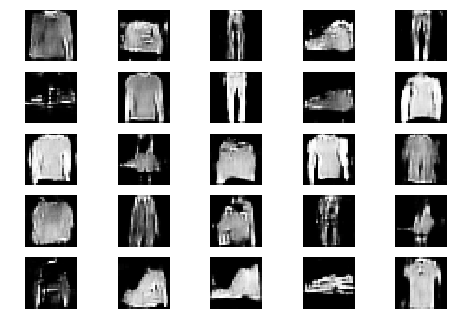

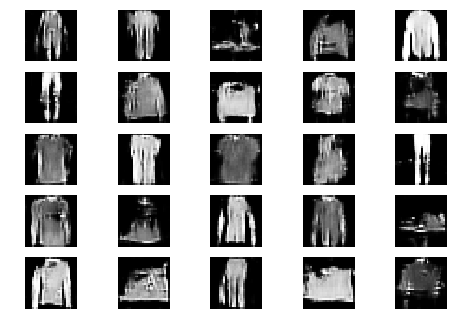

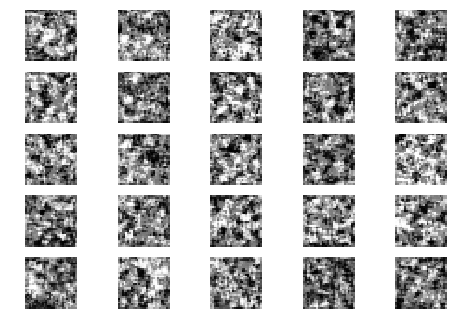

Epoch 0 Batch 1/937 [D loss: 0.679747, acc.: 65.62%] [G loss: 0.760382]
Epoch 0 Batch 2/937 [D loss: 0.562330, acc.: 75.00%] [G loss: 1.002090]
Epoch 0 Batch 3/937 [D loss: 0.730257, acc.: 56.25%] [G loss: 0.920785]
Epoch 0 Batch 4/937 [D loss: 0.448608, acc.: 81.25%] [G loss: 1.120829]
Epoch 0 Batch 5/937 [D loss: 0.627238, acc.: 68.75%] [G loss: 1.095930]
Epoch 0 Batch 6/937 [D loss: 0.499223, acc.: 75.00%] [G loss: 1.065459]
Epoch 0 Batch 7/937 [D loss: 0.457777, acc.: 78.12%] [G loss: 1.159026]
Epoch 0 Batch 8/937 [D loss: 0.444644, acc.: 75.00%] [G loss: 1.392778]
Epoch 0 Batch 9/937 [D loss: 0.523281, acc.: 78.12%] [G loss: 1.354187]
Epoch 0 Batch 10/937 [D loss: 0.436042, acc.: 84.38%] [G loss: 1.158080]
Epoch 0 Batch 11/937 [D loss: 0.424917, acc.: 81.25%] [G loss: 1.360909]
Epoch 0 Batch 12/937 [D loss: 0.374323, acc.: 84.38%] [G loss: 1.166520]
Epoch 0 Batch 13/937 [D loss: 0.432585, acc.: 84.38%] [G loss: 1.718015]
Epoch 0 Batch 14/937 [D loss: 0.550868, acc.: 62.50%] [G los

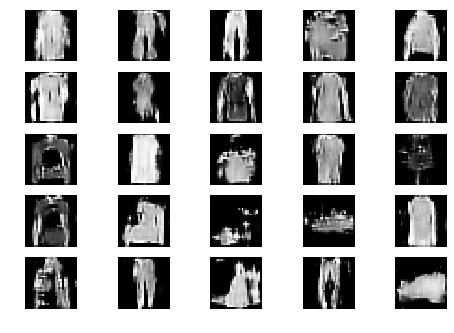

Epoch 0 Batch 101/937 [D loss: 0.763147, acc.: 59.38%] [G loss: 1.007643]


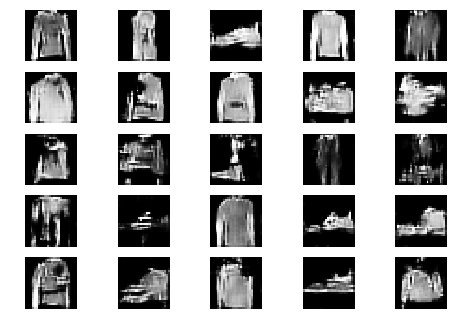

Epoch 0 Batch 102/937 [D loss: 0.509571, acc.: 75.00%] [G loss: 1.735656]


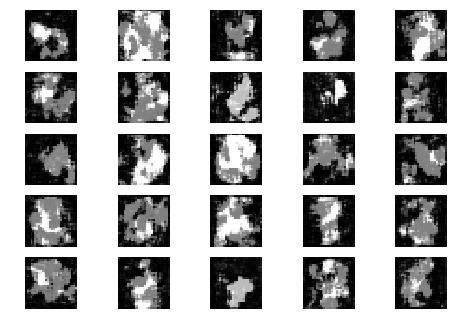

Epoch 0 Batch 103/937 [D loss: 0.899183, acc.: 43.75%] [G loss: 1.302637]
Epoch 0 Batch 104/937 [D loss: 0.760570, acc.: 68.75%] [G loss: 1.066372]
Epoch 0 Batch 105/937 [D loss: 0.615962, acc.: 68.75%] [G loss: 1.155670]
Epoch 0 Batch 106/937 [D loss: 0.710011, acc.: 71.88%] [G loss: 0.851835]
Epoch 0 Batch 107/937 [D loss: 0.570216, acc.: 65.62%] [G loss: 1.381312]
Epoch 0 Batch 108/937 [D loss: 0.754263, acc.: 53.12%] [G loss: 1.054330]
Epoch 0 Batch 109/937 [D loss: 0.526855, acc.: 71.88%] [G loss: 1.401833]
Epoch 0 Batch 110/937 [D loss: 0.746979, acc.: 50.00%] [G loss: 1.297405]
Epoch 0 Batch 111/937 [D loss: 0.468855, acc.: 75.00%] [G loss: 1.216792]
Epoch 0 Batch 112/937 [D loss: 0.866936, acc.: 46.88%] [G loss: 1.219345]
Epoch 0 Batch 113/937 [D loss: 0.797132, acc.: 46.88%] [G loss: 1.433256]
Epoch 0 Batch 114/937 [D loss: 0.760856, acc.: 53.12%] [G loss: 1.393716]
Epoch 0 Batch 115/937 [D loss: 0.672491, acc.: 65.62%] [G loss: 1.005722]
Epoch 0 Batch 116/937 [D loss: 0.79353

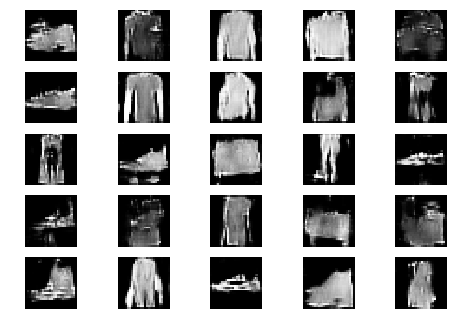

Epoch 0 Batch 201/937 [D loss: 0.625623, acc.: 65.62%] [G loss: 1.568747]
Epoch 0 Batch 202/937 [D loss: 0.495160, acc.: 75.00%] [G loss: 1.122547]


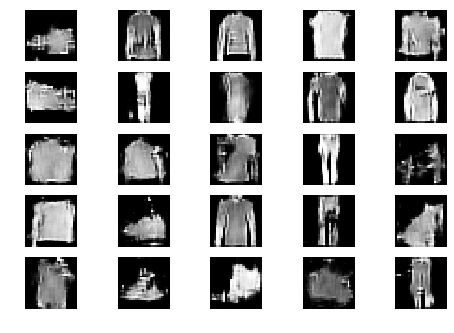

Epoch 0 Batch 203/937 [D loss: 0.636990, acc.: 56.25%] [G loss: 1.398764]
Epoch 0 Batch 204/937 [D loss: 0.543786, acc.: 71.88%] [G loss: 1.234658]


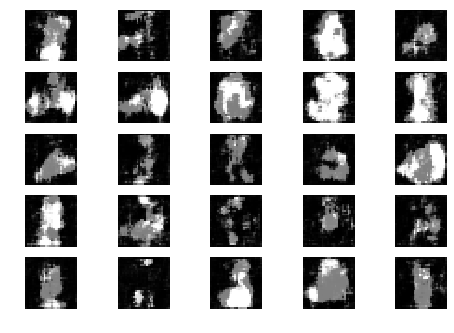

Epoch 0 Batch 205/937 [D loss: 0.390369, acc.: 81.25%] [G loss: 1.376459]
Epoch 0 Batch 206/937 [D loss: 0.547502, acc.: 71.88%] [G loss: 1.297151]
Epoch 0 Batch 207/937 [D loss: 0.567521, acc.: 68.75%] [G loss: 1.723936]
Epoch 0 Batch 208/937 [D loss: 0.689155, acc.: 65.62%] [G loss: 1.441158]
Epoch 0 Batch 209/937 [D loss: 0.678588, acc.: 62.50%] [G loss: 1.216077]
Epoch 0 Batch 210/937 [D loss: 0.570583, acc.: 56.25%] [G loss: 1.532954]
Epoch 0 Batch 211/937 [D loss: 0.537813, acc.: 68.75%] [G loss: 1.984698]
Epoch 0 Batch 212/937 [D loss: 0.746412, acc.: 62.50%] [G loss: 1.243805]
Epoch 0 Batch 213/937 [D loss: 0.592041, acc.: 65.62%] [G loss: 1.413679]
Epoch 0 Batch 214/937 [D loss: 0.506986, acc.: 68.75%] [G loss: 1.413352]
Epoch 0 Batch 215/937 [D loss: 0.681507, acc.: 68.75%] [G loss: 1.610565]
Epoch 0 Batch 216/937 [D loss: 0.639141, acc.: 68.75%] [G loss: 1.449877]
Epoch 0 Batch 217/937 [D loss: 0.704580, acc.: 68.75%] [G loss: 1.388810]
Epoch 0 Batch 218/937 [D loss: 0.70764

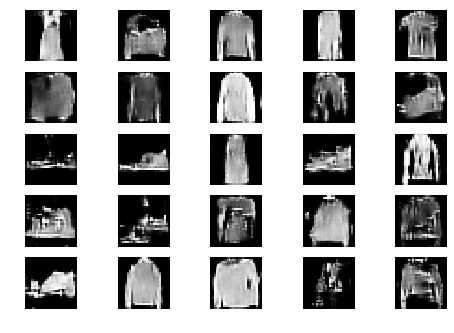

Epoch 0 Batch 301/937 [D loss: 0.478264, acc.: 81.25%] [G loss: 1.492446]
Epoch 0 Batch 302/937 [D loss: 0.461269, acc.: 78.12%] [G loss: 1.577834]
Epoch 0 Batch 303/937 [D loss: 0.495082, acc.: 78.12%] [G loss: 1.780178]


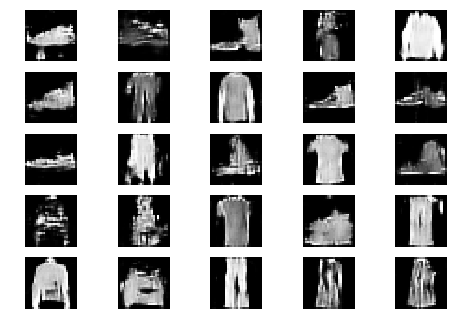

Epoch 0 Batch 304/937 [D loss: 0.503153, acc.: 81.25%] [G loss: 1.874221]
Epoch 0 Batch 305/937 [D loss: 0.553704, acc.: 71.88%] [G loss: 1.346881]
Epoch 0 Batch 306/937 [D loss: 0.404913, acc.: 84.38%] [G loss: 2.215486]


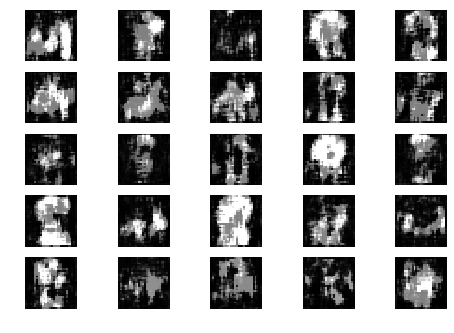

Epoch 0 Batch 307/937 [D loss: 0.732534, acc.: 56.25%] [G loss: 1.611719]
Epoch 0 Batch 308/937 [D loss: 0.491284, acc.: 71.88%] [G loss: 1.439640]
Epoch 0 Batch 309/937 [D loss: 0.500326, acc.: 71.88%] [G loss: 1.354759]
Epoch 0 Batch 310/937 [D loss: 0.441822, acc.: 84.38%] [G loss: 1.664262]
Epoch 0 Batch 311/937 [D loss: 0.321886, acc.: 90.62%] [G loss: 1.527969]
Epoch 0 Batch 312/937 [D loss: 0.515326, acc.: 78.12%] [G loss: 1.516440]
Epoch 0 Batch 313/937 [D loss: 0.482822, acc.: 68.75%] [G loss: 1.737453]
Epoch 0 Batch 314/937 [D loss: 0.548908, acc.: 71.88%] [G loss: 1.872195]
Epoch 0 Batch 315/937 [D loss: 0.466837, acc.: 81.25%] [G loss: 1.730884]
Epoch 0 Batch 316/937 [D loss: 0.447472, acc.: 81.25%] [G loss: 1.764570]
Epoch 0 Batch 317/937 [D loss: 0.368055, acc.: 84.38%] [G loss: 1.810785]
Epoch 0 Batch 318/937 [D loss: 0.505716, acc.: 71.88%] [G loss: 1.426144]
Epoch 0 Batch 319/937 [D loss: 0.537620, acc.: 78.12%] [G loss: 1.414898]
Epoch 0 Batch 320/937 [D loss: 0.53819

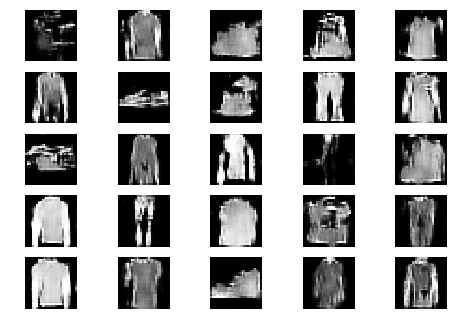

Epoch 0 Batch 401/937 [D loss: 0.499378, acc.: 87.50%] [G loss: 2.026685]
Epoch 0 Batch 402/937 [D loss: 0.490736, acc.: 78.12%] [G loss: 2.571691]
Epoch 0 Batch 403/937 [D loss: 0.216281, acc.: 93.75%] [G loss: 2.332356]
Epoch 0 Batch 404/937 [D loss: 0.466430, acc.: 65.62%] [G loss: 2.064156]


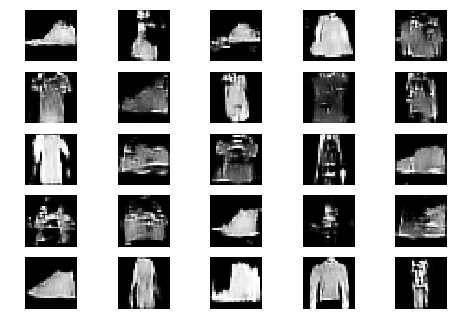

Epoch 0 Batch 405/937 [D loss: 0.478347, acc.: 75.00%] [G loss: 1.670998]
Epoch 0 Batch 406/937 [D loss: 0.352787, acc.: 81.25%] [G loss: 2.295398]
Epoch 0 Batch 407/937 [D loss: 0.307434, acc.: 93.75%] [G loss: 2.296633]
Epoch 0 Batch 408/937 [D loss: 0.377077, acc.: 87.50%] [G loss: 1.884530]


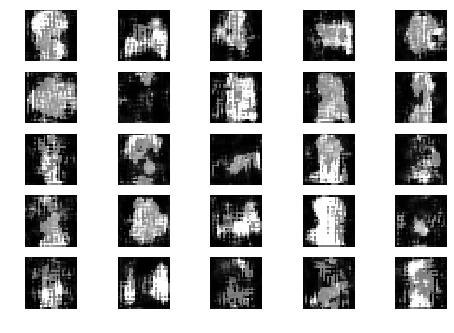

Epoch 0 Batch 409/937 [D loss: 0.381381, acc.: 84.38%] [G loss: 2.207416]
Epoch 0 Batch 410/937 [D loss: 0.717494, acc.: 56.25%] [G loss: 2.583513]
Epoch 0 Batch 411/937 [D loss: 0.571610, acc.: 71.88%] [G loss: 2.442805]
Epoch 0 Batch 412/937 [D loss: 0.628528, acc.: 75.00%] [G loss: 1.288771]
Epoch 0 Batch 413/937 [D loss: 0.559036, acc.: 68.75%] [G loss: 1.783525]
Epoch 0 Batch 414/937 [D loss: 0.507518, acc.: 84.38%] [G loss: 2.132336]
Epoch 0 Batch 415/937 [D loss: 0.792880, acc.: 62.50%] [G loss: 2.026189]
Epoch 0 Batch 416/937 [D loss: 0.346911, acc.: 87.50%] [G loss: 2.222185]
Epoch 0 Batch 417/937 [D loss: 0.685331, acc.: 71.88%] [G loss: 1.370736]
Epoch 0 Batch 418/937 [D loss: 0.841311, acc.: 53.12%] [G loss: 1.407234]
Epoch 0 Batch 419/937 [D loss: 0.301568, acc.: 90.62%] [G loss: 1.605303]
Epoch 0 Batch 420/937 [D loss: 0.441562, acc.: 78.12%] [G loss: 1.924361]
Epoch 0 Batch 421/937 [D loss: 0.664094, acc.: 59.38%] [G loss: 2.057571]
Epoch 0 Batch 422/937 [D loss: 0.78936

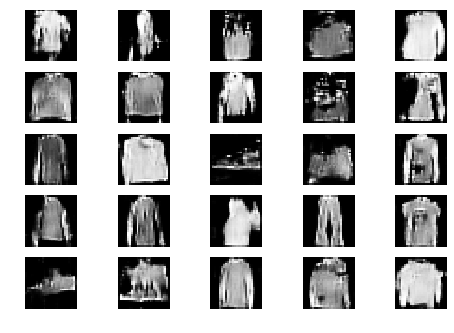

Epoch 0 Batch 501/937 [D loss: 0.495400, acc.: 84.38%] [G loss: 2.038147]
Epoch 0 Batch 502/937 [D loss: 0.561295, acc.: 71.88%] [G loss: 1.535870]
Epoch 0 Batch 503/937 [D loss: 0.662608, acc.: 68.75%] [G loss: 1.681172]
Epoch 0 Batch 504/937 [D loss: 0.458474, acc.: 75.00%] [G loss: 2.020936]
Epoch 0 Batch 505/937 [D loss: 0.721303, acc.: 65.62%] [G loss: 1.501816]


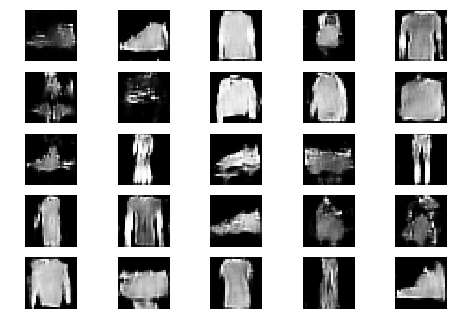

Epoch 0 Batch 506/937 [D loss: 0.623236, acc.: 65.62%] [G loss: 2.340710]
Epoch 0 Batch 507/937 [D loss: 0.557474, acc.: 71.88%] [G loss: 1.905803]
Epoch 0 Batch 508/937 [D loss: 0.560216, acc.: 75.00%] [G loss: 1.926558]
Epoch 0 Batch 509/937 [D loss: 0.395037, acc.: 78.12%] [G loss: 2.369283]
Epoch 0 Batch 510/937 [D loss: 0.626417, acc.: 62.50%] [G loss: 1.727759]


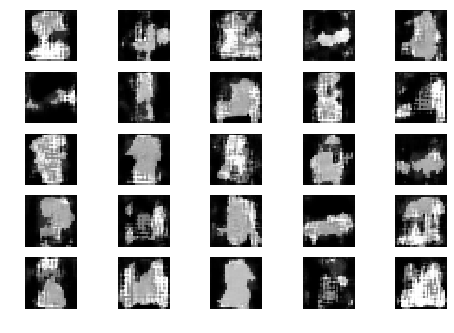

Epoch 0 Batch 511/937 [D loss: 0.663775, acc.: 71.88%] [G loss: 1.315930]
Epoch 0 Batch 512/937 [D loss: 0.540065, acc.: 78.12%] [G loss: 1.278411]
Epoch 0 Batch 513/937 [D loss: 0.418503, acc.: 81.25%] [G loss: 1.508978]
Epoch 0 Batch 514/937 [D loss: 0.452854, acc.: 81.25%] [G loss: 2.187330]
Epoch 0 Batch 515/937 [D loss: 0.492433, acc.: 68.75%] [G loss: 1.422566]
Epoch 0 Batch 516/937 [D loss: 0.559985, acc.: 71.88%] [G loss: 1.249741]
Epoch 0 Batch 517/937 [D loss: 0.391976, acc.: 78.12%] [G loss: 1.478098]
Epoch 0 Batch 518/937 [D loss: 0.592858, acc.: 68.75%] [G loss: 1.626845]
Epoch 0 Batch 519/937 [D loss: 0.373396, acc.: 84.38%] [G loss: 1.774839]
Epoch 0 Batch 520/937 [D loss: 0.670255, acc.: 56.25%] [G loss: 1.461259]
Epoch 0 Batch 521/937 [D loss: 0.319259, acc.: 87.50%] [G loss: 2.002148]
Epoch 0 Batch 522/937 [D loss: 0.413528, acc.: 84.38%] [G loss: 1.849376]
Epoch 0 Batch 523/937 [D loss: 0.568718, acc.: 75.00%] [G loss: 1.922313]
Epoch 0 Batch 524/937 [D loss: 0.43951

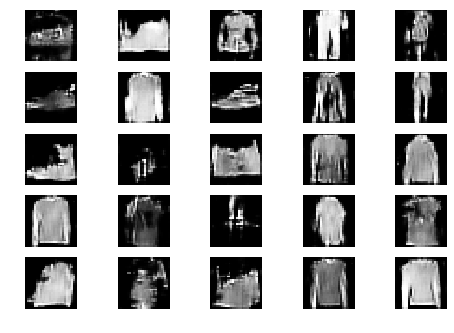

Epoch 0 Batch 601/937 [D loss: 0.461905, acc.: 87.50%] [G loss: 1.908415]
Epoch 0 Batch 602/937 [D loss: 0.572861, acc.: 71.88%] [G loss: 1.981339]
Epoch 0 Batch 603/937 [D loss: 0.337519, acc.: 81.25%] [G loss: 2.050176]
Epoch 0 Batch 604/937 [D loss: 0.531031, acc.: 68.75%] [G loss: 1.736188]
Epoch 0 Batch 605/937 [D loss: 0.352957, acc.: 81.25%] [G loss: 1.956884]
Epoch 0 Batch 606/937 [D loss: 0.593247, acc.: 65.62%] [G loss: 2.053016]


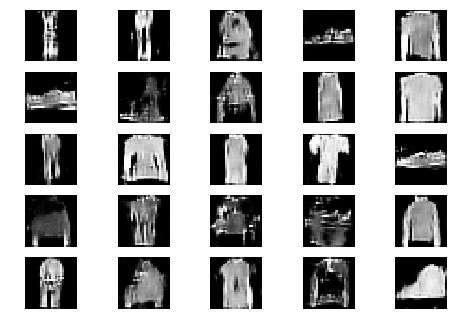

Epoch 0 Batch 607/937 [D loss: 0.388953, acc.: 81.25%] [G loss: 2.122748]
Epoch 0 Batch 608/937 [D loss: 0.432067, acc.: 84.38%] [G loss: 2.096455]
Epoch 0 Batch 609/937 [D loss: 0.689108, acc.: 65.62%] [G loss: 1.996785]
Epoch 0 Batch 610/937 [D loss: 0.565508, acc.: 65.62%] [G loss: 1.941273]
Epoch 0 Batch 611/937 [D loss: 0.347329, acc.: 87.50%] [G loss: 1.576810]
Epoch 0 Batch 612/937 [D loss: 0.406592, acc.: 84.38%] [G loss: 1.660465]


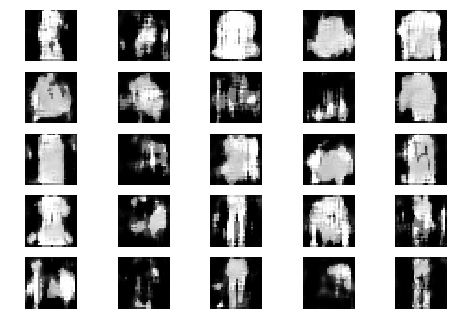

Epoch 0 Batch 613/937 [D loss: 0.541977, acc.: 81.25%] [G loss: 2.296398]
Epoch 0 Batch 614/937 [D loss: 0.366389, acc.: 81.25%] [G loss: 2.191166]
Epoch 0 Batch 615/937 [D loss: 0.408201, acc.: 81.25%] [G loss: 2.017595]
Epoch 0 Batch 616/937 [D loss: 0.588833, acc.: 75.00%] [G loss: 1.319054]
Epoch 0 Batch 617/937 [D loss: 0.506508, acc.: 68.75%] [G loss: 1.482524]
Epoch 0 Batch 618/937 [D loss: 0.366789, acc.: 87.50%] [G loss: 1.812092]
Epoch 0 Batch 619/937 [D loss: 0.379940, acc.: 84.38%] [G loss: 2.321925]
Epoch 0 Batch 620/937 [D loss: 0.356544, acc.: 84.38%] [G loss: 2.257523]
Epoch 0 Batch 621/937 [D loss: 0.380673, acc.: 84.38%] [G loss: 2.238944]
Epoch 0 Batch 622/937 [D loss: 0.474028, acc.: 78.12%] [G loss: 1.897064]
Epoch 0 Batch 623/937 [D loss: 0.517431, acc.: 81.25%] [G loss: 1.860877]
Epoch 0 Batch 624/937 [D loss: 0.359100, acc.: 87.50%] [G loss: 1.876116]
Epoch 0 Batch 625/937 [D loss: 0.570881, acc.: 68.75%] [G loss: 1.820398]
Epoch 0 Batch 626/937 [D loss: 0.51046

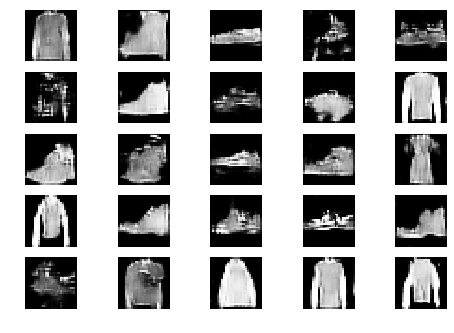

Epoch 0 Batch 701/937 [D loss: 0.421445, acc.: 84.38%] [G loss: 2.108804]
Epoch 0 Batch 702/937 [D loss: 0.422204, acc.: 81.25%] [G loss: 1.738301]
Epoch 0 Batch 703/937 [D loss: 0.513138, acc.: 71.88%] [G loss: 1.904401]
Epoch 0 Batch 704/937 [D loss: 0.249605, acc.: 96.88%] [G loss: 2.340904]
Epoch 0 Batch 705/937 [D loss: 0.532651, acc.: 65.62%] [G loss: 1.369714]
Epoch 0 Batch 706/937 [D loss: 0.572690, acc.: 68.75%] [G loss: 1.794811]
Epoch 0 Batch 707/937 [D loss: 0.337496, acc.: 81.25%] [G loss: 2.321680]


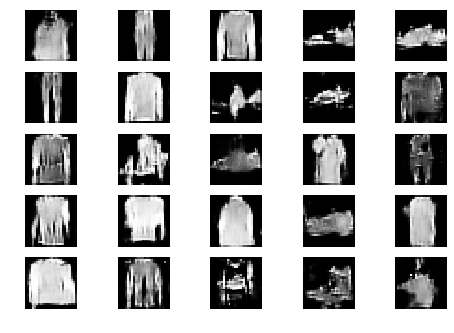

Epoch 0 Batch 708/937 [D loss: 0.329569, acc.: 81.25%] [G loss: 2.634202]
Epoch 0 Batch 709/937 [D loss: 0.436516, acc.: 87.50%] [G loss: 1.546623]
Epoch 0 Batch 710/937 [D loss: 0.552508, acc.: 75.00%] [G loss: 1.377052]
Epoch 0 Batch 711/937 [D loss: 0.547495, acc.: 65.62%] [G loss: 1.813535]
Epoch 0 Batch 712/937 [D loss: 0.329876, acc.: 84.38%] [G loss: 1.790593]
Epoch 0 Batch 713/937 [D loss: 0.594137, acc.: 78.12%] [G loss: 2.271264]
Epoch 0 Batch 714/937 [D loss: 0.370515, acc.: 81.25%] [G loss: 1.869256]


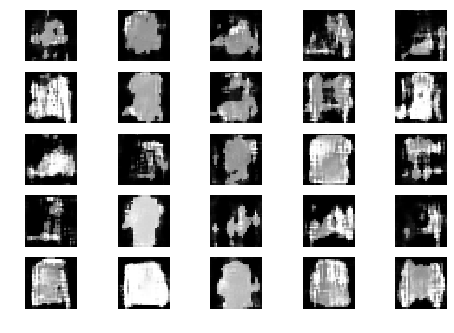

Epoch 0 Batch 715/937 [D loss: 0.472139, acc.: 81.25%] [G loss: 1.122720]
Epoch 0 Batch 716/937 [D loss: 0.481588, acc.: 75.00%] [G loss: 1.014617]
Epoch 0 Batch 717/937 [D loss: 0.244755, acc.: 87.50%] [G loss: 1.616457]
Epoch 0 Batch 718/937 [D loss: 0.601439, acc.: 71.88%] [G loss: 1.455697]
Epoch 0 Batch 719/937 [D loss: 0.790312, acc.: 59.38%] [G loss: 1.902574]
Epoch 0 Batch 720/937 [D loss: 0.552870, acc.: 68.75%] [G loss: 2.777514]
Epoch 0 Batch 721/937 [D loss: 0.406722, acc.: 84.38%] [G loss: 1.951694]
Epoch 0 Batch 722/937 [D loss: 0.601428, acc.: 62.50%] [G loss: 2.044510]
Epoch 0 Batch 723/937 [D loss: 0.602043, acc.: 65.62%] [G loss: 1.998529]
Epoch 0 Batch 724/937 [D loss: 0.416958, acc.: 75.00%] [G loss: 1.919361]
Epoch 0 Batch 725/937 [D loss: 1.101191, acc.: 40.62%] [G loss: 1.729859]
Epoch 0 Batch 726/937 [D loss: 0.626238, acc.: 62.50%] [G loss: 1.360746]
Epoch 0 Batch 727/937 [D loss: 0.469455, acc.: 78.12%] [G loss: 2.141059]
Epoch 0 Batch 728/937 [D loss: 0.31004

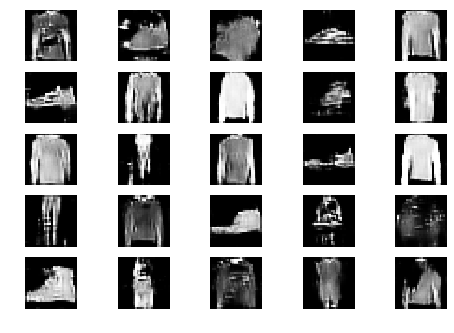

Epoch 0 Batch 801/937 [D loss: 1.020239, acc.: 31.25%] [G loss: 2.088670]
Epoch 0 Batch 802/937 [D loss: 0.521754, acc.: 75.00%] [G loss: 1.881639]
Epoch 0 Batch 803/937 [D loss: 0.304850, acc.: 81.25%] [G loss: 2.035779]
Epoch 0 Batch 804/937 [D loss: 0.335705, acc.: 87.50%] [G loss: 1.999122]
Epoch 0 Batch 805/937 [D loss: 0.490885, acc.: 68.75%] [G loss: 2.128960]
Epoch 0 Batch 806/937 [D loss: 0.370151, acc.: 84.38%] [G loss: 2.197459]
Epoch 0 Batch 807/937 [D loss: 0.250429, acc.: 96.88%] [G loss: 2.339840]
Epoch 0 Batch 808/937 [D loss: 0.806575, acc.: 56.25%] [G loss: 1.892257]


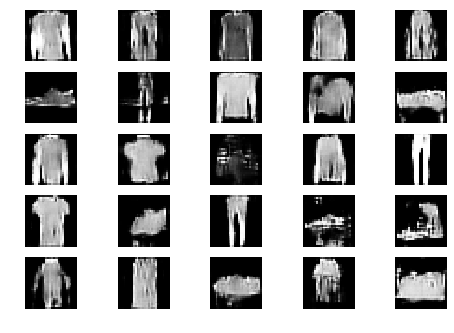

Epoch 0 Batch 809/937 [D loss: 0.352913, acc.: 84.38%] [G loss: 1.905063]
Epoch 0 Batch 810/937 [D loss: 0.419543, acc.: 81.25%] [G loss: 1.864221]
Epoch 0 Batch 811/937 [D loss: 0.536386, acc.: 71.88%] [G loss: 1.713408]
Epoch 0 Batch 812/937 [D loss: 0.393151, acc.: 84.38%] [G loss: 2.106397]
Epoch 0 Batch 813/937 [D loss: 0.406326, acc.: 78.12%] [G loss: 2.091297]
Epoch 0 Batch 814/937 [D loss: 0.539242, acc.: 75.00%] [G loss: 1.987322]
Epoch 0 Batch 815/937 [D loss: 0.401692, acc.: 87.50%] [G loss: 1.881065]
Epoch 0 Batch 816/937 [D loss: 0.689784, acc.: 62.50%] [G loss: 1.630505]


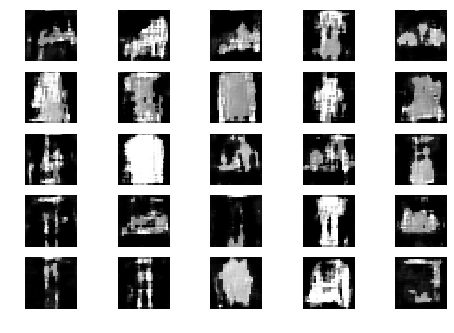

Epoch 0 Batch 817/937 [D loss: 0.695333, acc.: 62.50%] [G loss: 1.562264]
Epoch 0 Batch 818/937 [D loss: 0.524175, acc.: 75.00%] [G loss: 1.917548]
Epoch 0 Batch 819/937 [D loss: 0.616506, acc.: 62.50%] [G loss: 1.604959]
Epoch 0 Batch 820/937 [D loss: 0.568929, acc.: 78.12%] [G loss: 2.143549]
Epoch 0 Batch 821/937 [D loss: 0.534843, acc.: 75.00%] [G loss: 1.523611]
Epoch 0 Batch 822/937 [D loss: 0.479806, acc.: 78.12%] [G loss: 2.356789]
Epoch 0 Batch 823/937 [D loss: 0.752135, acc.: 65.62%] [G loss: 1.835667]
Epoch 0 Batch 824/937 [D loss: 0.418740, acc.: 84.38%] [G loss: 1.997168]
Epoch 0 Batch 825/937 [D loss: 0.594666, acc.: 75.00%] [G loss: 1.527410]
Epoch 0 Batch 826/937 [D loss: 0.611107, acc.: 62.50%] [G loss: 1.558459]
Epoch 0 Batch 827/937 [D loss: 0.746840, acc.: 62.50%] [G loss: 2.153208]
Epoch 0 Batch 828/937 [D loss: 0.575959, acc.: 68.75%] [G loss: 2.577729]
Epoch 0 Batch 829/937 [D loss: 0.348787, acc.: 87.50%] [G loss: 2.648448]
Epoch 0 Batch 830/937 [D loss: 0.33731

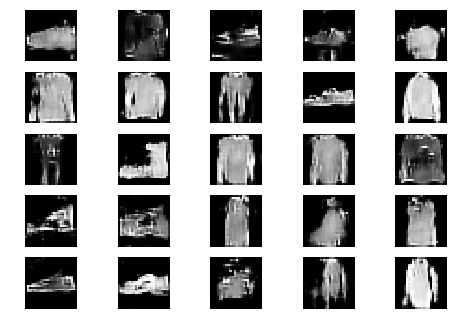

Epoch 0 Batch 901/937 [D loss: 0.613240, acc.: 71.88%] [G loss: 2.002566]
Epoch 0 Batch 902/937 [D loss: 0.515268, acc.: 78.12%] [G loss: 2.240796]
Epoch 0 Batch 903/937 [D loss: 0.853481, acc.: 65.62%] [G loss: 1.773016]
Epoch 0 Batch 904/937 [D loss: 0.448882, acc.: 78.12%] [G loss: 1.700288]
Epoch 0 Batch 905/937 [D loss: 0.782855, acc.: 59.38%] [G loss: 1.334069]
Epoch 0 Batch 906/937 [D loss: 0.367204, acc.: 84.38%] [G loss: 1.941670]
Epoch 0 Batch 907/937 [D loss: 0.458961, acc.: 75.00%] [G loss: 2.089336]
Epoch 0 Batch 908/937 [D loss: 0.993223, acc.: 56.25%] [G loss: 1.718069]
Epoch 0 Batch 909/937 [D loss: 0.647645, acc.: 56.25%] [G loss: 2.102406]


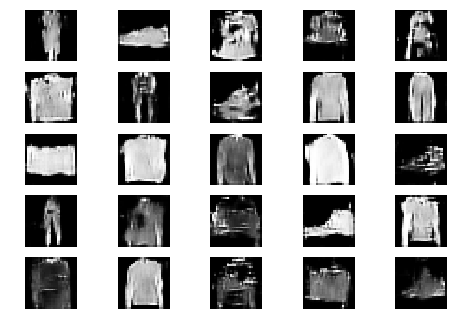

Epoch 0 Batch 910/937 [D loss: 0.532650, acc.: 62.50%] [G loss: 1.938775]
Epoch 0 Batch 911/937 [D loss: 0.669863, acc.: 68.75%] [G loss: 2.101951]
Epoch 0 Batch 912/937 [D loss: 0.528402, acc.: 81.25%] [G loss: 1.697575]
Epoch 0 Batch 913/937 [D loss: 0.451193, acc.: 81.25%] [G loss: 1.641755]
Epoch 0 Batch 914/937 [D loss: 0.819543, acc.: 56.25%] [G loss: 2.057452]
Epoch 0 Batch 915/937 [D loss: 0.501792, acc.: 81.25%] [G loss: 2.033305]
Epoch 0 Batch 916/937 [D loss: 0.450897, acc.: 71.88%] [G loss: 2.695401]
Epoch 0 Batch 917/937 [D loss: 0.761257, acc.: 65.62%] [G loss: 1.369938]
Epoch 0 Batch 918/937 [D loss: 0.428097, acc.: 81.25%] [G loss: 1.369061]


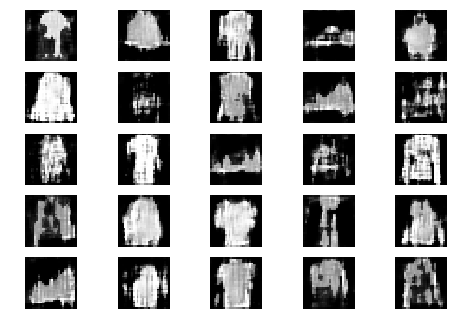

Epoch 0 Batch 919/937 [D loss: 0.876938, acc.: 46.88%] [G loss: 1.473572]
Epoch 0 Batch 920/937 [D loss: 0.481175, acc.: 81.25%] [G loss: 2.057353]
Epoch 0 Batch 921/937 [D loss: 0.510403, acc.: 71.88%] [G loss: 1.951394]
Epoch 0 Batch 922/937 [D loss: 0.413911, acc.: 90.62%] [G loss: 1.807142]
Epoch 0 Batch 923/937 [D loss: 0.542632, acc.: 75.00%] [G loss: 1.546562]
Epoch 0 Batch 924/937 [D loss: 0.707825, acc.: 62.50%] [G loss: 1.974493]
Epoch 0 Batch 925/937 [D loss: 0.566141, acc.: 78.12%] [G loss: 2.554704]
Epoch 0 Batch 926/937 [D loss: 0.920532, acc.: 43.75%] [G loss: 1.770088]
Epoch 0 Batch 927/937 [D loss: 0.651426, acc.: 65.62%] [G loss: 1.279830]
Epoch 0 Batch 928/937 [D loss: 0.661982, acc.: 65.62%] [G loss: 1.616041]
Epoch 0 Batch 929/937 [D loss: 0.453287, acc.: 78.12%] [G loss: 1.971424]
Epoch 0 Batch 930/937 [D loss: 0.633676, acc.: 65.62%] [G loss: 2.566583]
Epoch 0 Batch 931/937 [D loss: 0.562306, acc.: 68.75%] [G loss: 2.004646]
Epoch 0 Batch 932/937 [D loss: 0.45452

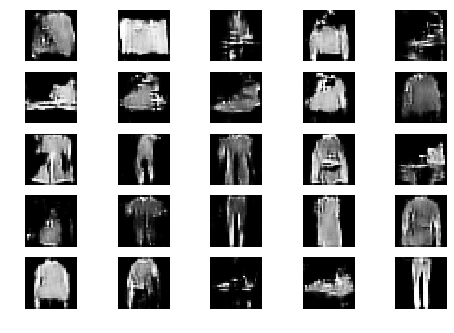

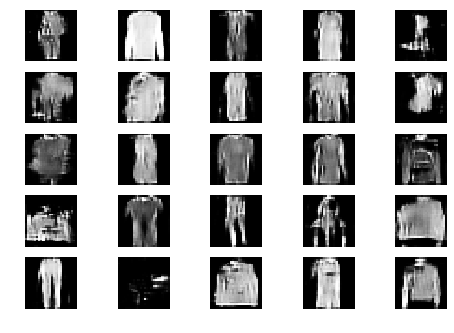

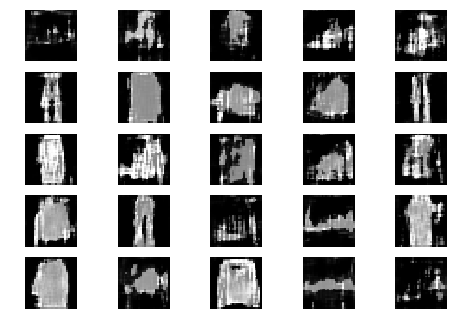

Epoch 1 Batch 1/937 [D loss: 0.478101, acc.: 75.00%] [G loss: 2.452528]
Epoch 1 Batch 2/937 [D loss: 0.396437, acc.: 78.12%] [G loss: 1.721236]
Epoch 1 Batch 3/937 [D loss: 0.458599, acc.: 68.75%] [G loss: 1.727880]
Epoch 1 Batch 4/937 [D loss: 0.479410, acc.: 71.88%] [G loss: 1.394234]
Epoch 1 Batch 5/937 [D loss: 0.656735, acc.: 56.25%] [G loss: 2.098037]
Epoch 1 Batch 6/937 [D loss: 0.362148, acc.: 87.50%] [G loss: 2.123369]
Epoch 1 Batch 7/937 [D loss: 0.548280, acc.: 65.62%] [G loss: 1.967266]
Epoch 1 Batch 8/937 [D loss: 0.639123, acc.: 75.00%] [G loss: 1.462349]
Epoch 1 Batch 9/937 [D loss: 0.597120, acc.: 62.50%] [G loss: 1.513401]
Epoch 1 Batch 10/937 [D loss: 0.335557, acc.: 90.62%] [G loss: 1.646040]
Epoch 1 Batch 11/937 [D loss: 0.461455, acc.: 84.38%] [G loss: 1.842659]
Epoch 1 Batch 12/937 [D loss: 0.694754, acc.: 56.25%] [G loss: 1.223153]
Epoch 1 Batch 13/937 [D loss: 0.911868, acc.: 53.12%] [G loss: 1.379787]
Epoch 1 Batch 14/937 [D loss: 0.461963, acc.: 78.12%] [G los

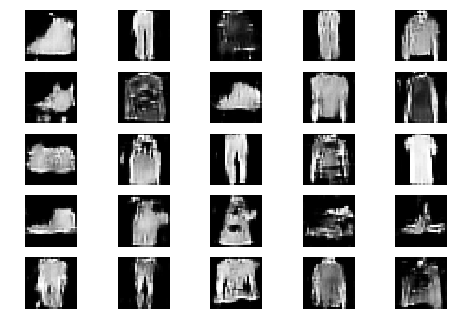

Epoch 1 Batch 101/937 [D loss: 0.390092, acc.: 78.12%] [G loss: 1.584990]


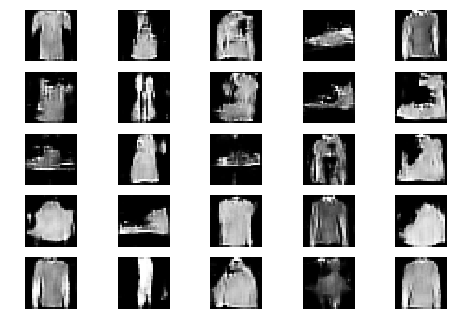

Epoch 1 Batch 102/937 [D loss: 0.387924, acc.: 84.38%] [G loss: 1.979003]


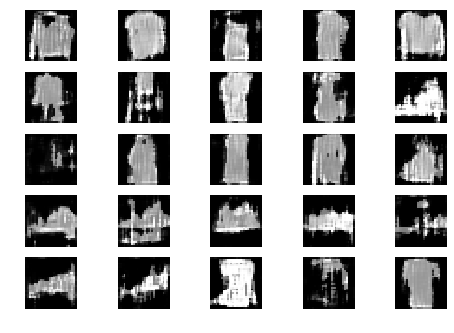

Epoch 1 Batch 103/937 [D loss: 0.575580, acc.: 68.75%] [G loss: 2.067433]
Epoch 1 Batch 104/937 [D loss: 0.535130, acc.: 75.00%] [G loss: 1.885318]
Epoch 1 Batch 105/937 [D loss: 0.440000, acc.: 75.00%] [G loss: 1.876833]
Epoch 1 Batch 106/937 [D loss: 0.588781, acc.: 71.88%] [G loss: 2.291737]
Epoch 1 Batch 107/937 [D loss: 0.802254, acc.: 53.12%] [G loss: 1.630734]
Epoch 1 Batch 108/937 [D loss: 0.803155, acc.: 53.12%] [G loss: 1.195666]
Epoch 1 Batch 109/937 [D loss: 0.478307, acc.: 75.00%] [G loss: 1.393272]
Epoch 1 Batch 110/937 [D loss: 0.634031, acc.: 62.50%] [G loss: 1.547096]
Epoch 1 Batch 111/937 [D loss: 0.407524, acc.: 84.38%] [G loss: 1.210980]
Epoch 1 Batch 112/937 [D loss: 0.308689, acc.: 87.50%] [G loss: 1.682974]
Epoch 1 Batch 113/937 [D loss: 0.904641, acc.: 53.12%] [G loss: 1.362252]
Epoch 1 Batch 114/937 [D loss: 0.788842, acc.: 59.38%] [G loss: 1.487836]
Epoch 1 Batch 115/937 [D loss: 0.338784, acc.: 93.75%] [G loss: 1.426682]
Epoch 1 Batch 116/937 [D loss: 0.50940

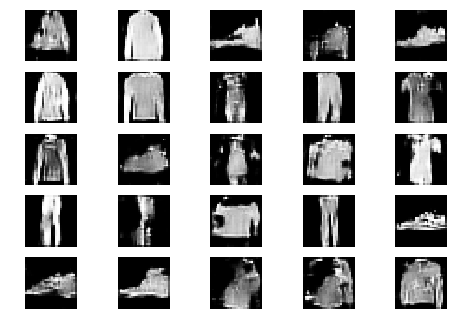

Epoch 1 Batch 201/937 [D loss: 0.315597, acc.: 93.75%] [G loss: 1.977899]
Epoch 1 Batch 202/937 [D loss: 0.593337, acc.: 75.00%] [G loss: 1.546631]


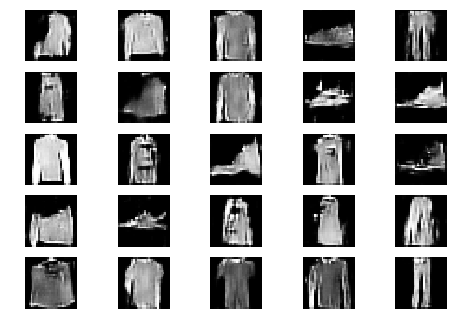

Epoch 1 Batch 203/937 [D loss: 0.553259, acc.: 81.25%] [G loss: 1.503862]
Epoch 1 Batch 204/937 [D loss: 0.502081, acc.: 71.88%] [G loss: 1.313127]


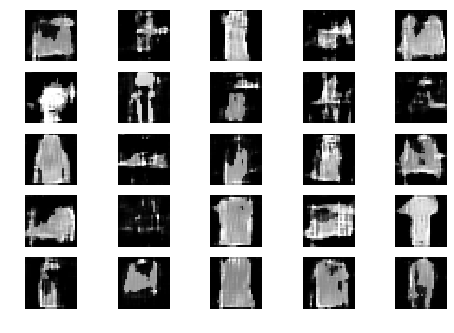

Epoch 1 Batch 205/937 [D loss: 0.789161, acc.: 65.62%] [G loss: 1.370074]
Epoch 1 Batch 206/937 [D loss: 0.397972, acc.: 78.12%] [G loss: 1.703359]
Epoch 1 Batch 207/937 [D loss: 0.480869, acc.: 71.88%] [G loss: 1.941081]
Epoch 1 Batch 208/937 [D loss: 0.470495, acc.: 68.75%] [G loss: 1.671510]
Epoch 1 Batch 209/937 [D loss: 0.457386, acc.: 71.88%] [G loss: 2.230118]
Epoch 1 Batch 210/937 [D loss: 0.583489, acc.: 65.62%] [G loss: 1.428997]
Epoch 1 Batch 211/937 [D loss: 0.514851, acc.: 81.25%] [G loss: 1.613307]
Epoch 1 Batch 212/937 [D loss: 0.922659, acc.: 53.12%] [G loss: 1.466096]
Epoch 1 Batch 213/937 [D loss: 0.635467, acc.: 71.88%] [G loss: 1.654960]
Epoch 1 Batch 214/937 [D loss: 0.526541, acc.: 75.00%] [G loss: 1.015632]
Epoch 1 Batch 215/937 [D loss: 0.490677, acc.: 78.12%] [G loss: 1.675957]
Epoch 1 Batch 216/937 [D loss: 0.632781, acc.: 59.38%] [G loss: 1.478202]
Epoch 1 Batch 217/937 [D loss: 0.902618, acc.: 53.12%] [G loss: 1.114277]
Epoch 1 Batch 218/937 [D loss: 0.37678

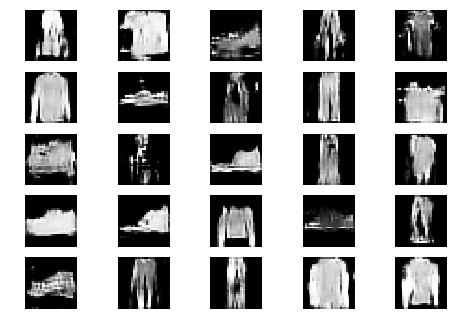

Epoch 1 Batch 301/937 [D loss: 0.483174, acc.: 75.00%] [G loss: 1.147104]
Epoch 1 Batch 302/937 [D loss: 0.620733, acc.: 59.38%] [G loss: 1.408869]
Epoch 1 Batch 303/937 [D loss: 0.680608, acc.: 59.38%] [G loss: 1.095733]


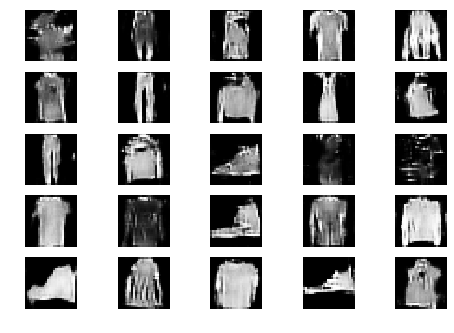

Epoch 1 Batch 304/937 [D loss: 0.504024, acc.: 75.00%] [G loss: 1.419138]
Epoch 1 Batch 305/937 [D loss: 0.496323, acc.: 71.88%] [G loss: 1.298212]
Epoch 1 Batch 306/937 [D loss: 0.548486, acc.: 75.00%] [G loss: 1.293492]


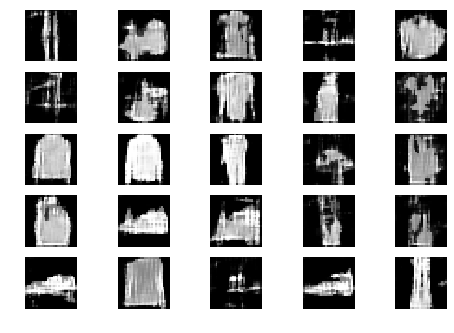

Epoch 1 Batch 307/937 [D loss: 0.576843, acc.: 75.00%] [G loss: 1.471908]
Epoch 1 Batch 308/937 [D loss: 0.507652, acc.: 71.88%] [G loss: 1.562846]
Epoch 1 Batch 309/937 [D loss: 0.718731, acc.: 59.38%] [G loss: 1.255620]
Epoch 1 Batch 310/937 [D loss: 0.637774, acc.: 65.62%] [G loss: 1.575353]
Epoch 1 Batch 311/937 [D loss: 0.695599, acc.: 62.50%] [G loss: 1.740190]
Epoch 1 Batch 312/937 [D loss: 0.596075, acc.: 71.88%] [G loss: 2.021594]
Epoch 1 Batch 313/937 [D loss: 0.511469, acc.: 78.12%] [G loss: 1.797343]
Epoch 1 Batch 314/937 [D loss: 0.645840, acc.: 59.38%] [G loss: 1.421857]
Epoch 1 Batch 315/937 [D loss: 0.559451, acc.: 71.88%] [G loss: 1.202615]
Epoch 1 Batch 316/937 [D loss: 0.677989, acc.: 68.75%] [G loss: 1.364322]
Epoch 1 Batch 317/937 [D loss: 0.640014, acc.: 65.62%] [G loss: 1.382684]
Epoch 1 Batch 318/937 [D loss: 0.355633, acc.: 87.50%] [G loss: 1.599375]
Epoch 1 Batch 319/937 [D loss: 0.440632, acc.: 81.25%] [G loss: 1.270829]
Epoch 1 Batch 320/937 [D loss: 0.77557

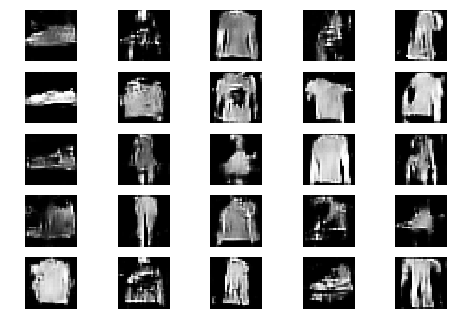

Epoch 1 Batch 401/937 [D loss: 0.737184, acc.: 65.62%] [G loss: 1.437113]
Epoch 1 Batch 402/937 [D loss: 0.587744, acc.: 75.00%] [G loss: 1.341032]
Epoch 1 Batch 403/937 [D loss: 0.753157, acc.: 59.38%] [G loss: 1.325837]
Epoch 1 Batch 404/937 [D loss: 0.578007, acc.: 71.88%] [G loss: 1.390638]


In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1, modeltotrain=3)

In [0]:
plotamodel(combined)
files.download('model.png')

In [0]:
!rm -rf generatorTrainedepoch2.h5

generator1.save('generator1fminst.h5')

!rm -rf generator2Trainedepoch2.h5

generator2.save('generator2fminst.h5')


In [0]:
generator1 = generator1.load_weights('generator1fmnist.h5')

In [0]:
generator2 = generator2.load_weights('generator2fmnist.h5')

In [0]:
train(generator1, generator2,  discriminator, combined, mergedmodel,  epochs=2, batch_size=32, save_interval=1)

In [0]:
generator1.save('generatorTrained1epoch4.h5')

In [0]:
files.download('generator1fmnist.h5')

In [0]:
files.download('generator2fmnist.h5')

In [0]:
##files.download('discriminator1.h5')

In [0]:
##files.download('combined1.h5')

In [0]:
#generator1 = load_model('generator1.h5')
#discriminator1 = load_model('discriminator1.h5')
#combined1 = load_model('combined1.h5')

